In [14]:
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from copy import deepcopy
import pandas as pd
from matplotlib import ticker as mticker
import tensorflow as tf
from tensorflow_probability import distributions as tfd
import utils.utils as utils
import utils.dataloader_utils as dataloader_utils
import os

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Evaluation 1: Evaluating AIC and BIC (ego)

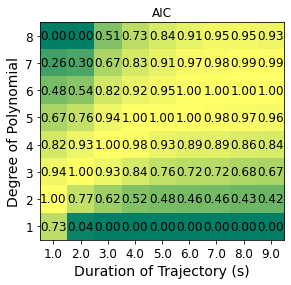

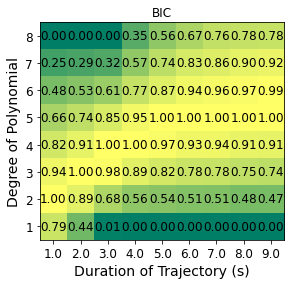

In [3]:
# Visualise AIC, BIC
num_of_points_list = [11, 21, 31, 41, 51, 61, 71, 81, 91]
degrees = [1, 2, 3, 4, 5, 6, 7, 8]
AIC_matrix = np.zeros((8, len(num_of_points_list)))
BIC_matrix = np.zeros((8, len(num_of_points_list)))
fig, ax = plt.subplots()
fig2, ax2 = plt.subplots()
cmap = mpl.cm.summer
for idx, num_of_points in enumerate(num_of_points_list):
    folder_dir = 'logs/gradient_tape/ego_xy' + str(num_of_points)
    file_name = 'result_summary'
    with open(folder_dir + '/' + file_name + '.json', "r") as read_file:
        result = json.load(read_file)
    AIC_score = np.array(result['aic_scores'])

    AIC_score = -AIC_score # reverse the score, so that the higher the better
    AIC_score_norm = (AIC_score - np.amin(AIC_score))/(np.amax(AIC_score) - np.amin(AIC_score))
    AIC_matrix[:, idx] = AIC_score_norm[::-1]
    
    BIC_score = np.array(result['bic_scores'])

    BIC_score = -BIC_score # reverse the score, so that the higher the better
    BIC_score_norm = (BIC_score - np.amin(BIC_score))/(np.amax(BIC_score) - np.amin(BIC_score))
    BIC_matrix[:, idx] = BIC_score_norm[::-1]


ax.imshow(AIC_matrix, cmap = cmap)
for (i, j), z in np.ndenumerate(AIC_matrix):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')

ax.set_xticks(np.arange(0, AIC_matrix.shape[1], 1));
ax.set_yticks(np.arange(0, AIC_matrix.shape[0], 1));
ax.set_xticklabels((np.array(num_of_points_list)-1) / 10);
ax.set_yticklabels(degrees[::-1]);


ax2.imshow(BIC_matrix, cmap = cmap)
for (i, j), z in np.ndenumerate(BIC_matrix):
    ax2.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')

ax2.set_xticks(np.arange(0, BIC_matrix.shape[1], 1));
ax2.set_yticks(np.arange(0, BIC_matrix.shape[0], 1));
ax2.set_xticklabels((np.array(num_of_points_list)-1) / 10);
ax2.set_yticklabels(degrees[::-1]);

#ax.set_title('Normalized avg. AIC (higher value is better)')
ax.set_title('AIC')
ax.set_ylabel('Degree of Polynomial')
ax.set_xlabel('Duration of Trajectory (s)')

fig.show()
fig.savefig('imgs/Waymo Normalized AIC related to the Duration of Trajectory.jpg', dpi = 600)

#ax2.set_title('Normalized avg. BIC (higher value is better)')
ax2.set_title('BIC')
ax2.set_ylabel('Degree of Polynomial')
ax2.set_xlabel('Duration of Trajectory (s)')

fig2.show()
fig2.savefig('imgs/Waymo Normalized BIC related to the Duration of Trajectory.jpg', dpi = 600)

# Evaluation 2: Analyse Fitting Error (ego)

## Load Data

In [4]:
BATCH_SIZE = 1024
num_points_in_one_traj = 21

In [9]:
# Load results
prior_folder_dir = 'logs/gradient_tape/ego_xy' + str(num_points_in_one_traj) + '_new'
file_name = 'result_summary'

# Load prior parameters
with open(prior_folder_dir + '/' + file_name + '.json', "r") as read_file:
    result = json.load(read_file)

with open("data/ego_trajs_not_moving_indicies.json", "r") as read_file:
    idx_not_moving = set(json.load(read_file))
    
with open("data/ego_trajs_" + str(num_points_in_one_traj) + "_json_new/ego_trajs_outlier_indicies.json", "r") as read_file:
    idx_outlier = set(json.load(read_file))

idx_invalid = idx_outlier | idx_not_moving
    

list_dataset = dataloader_utils.generate_file_list_dataset('data/ego_trajs_json/', idx_invalid)
start_idx_dataset = dataloader_utils.generate_start_indicies_dataset("data/ego_trajs_" + str(num_points_in_one_traj) + "_json_new/ego_trajs_start_point_indicies.json", idx_invalid)

combined_dataset = tf.data.Dataset.zip((list_dataset, start_idx_dataset))

dataProcessor = dataloader_utils.DataProcessor(BATCH_SIZE, combined_dataset, num_points_in_one_traj, traj_type = 'ego_traj', with_heading=True)
dataProcessor.load_process()

print(dataProcessor.loaded_dataset.__len__())     

100%|██████████| 487002/487002 [00:00<00:00, 3064777.61it/s]


tf.Tensor(377, shape=(), dtype=int64)


In [6]:
with open("data/ego_trajs_" + str(num_points_in_one_traj) + "_json_new/ego_trajs_filtered_CA.json", "r") as read_file:
    ego_smoothed_traj = np.array(json.load(read_file))[:, :, [0,3]] 

In [7]:
def preprocess_smoothed_ego_trajs(ego_trajs_smooth, idx_invalid):
    idx_valid = list(set(range(ego_trajs_smooth.shape[0])) - set(idx_invalid))
    ego_trajs_smooth = ego_trajs_smooth[idx_valid]
            
    return ego_trajs_smooth

smoothed_traj_dataset = tf.data.Dataset.from_tensor_slices(preprocess_smoothed_ego_trajs(ego_smoothed_traj, idx_invalid))
smoothed_traj_dataset = smoothed_traj_dataset.batch(BATCH_SIZE)
print(smoothed_traj_dataset.__len__())  

tf.Tensor(377, shape=(), dtype=int64)


In [12]:
degrees = result['degree']


errors_gt_poly_lon = np.zeros((len(degrees), start_idx_dataset.__len__(),  num_points_in_one_traj))
errors_gt_poly_lat = np.zeros((len(degrees), start_idx_dataset.__len__(), num_points_in_one_traj))

errors_kf_poly_lon = np.zeros((len(degrees), start_idx_dataset.__len__(), num_points_in_one_traj))
errors_kf_poly_lat = np.zeros((len(degrees), start_idx_dataset.__len__(), num_points_in_one_traj))

errors_gt_kf_lon = np.zeros((start_idx_dataset.__len__(), num_points_in_one_traj))
errors_gt_kf_lat = np.zeros((start_idx_dataset.__len__(), num_points_in_one_traj))

for idx_deg, deg in enumerate(tqdm(degrees)):
    current_batch_idx = 0
    print('Processing deg: ', deg)
    
    for (t_samples, mess_traj_samples, heading_samples), ks_traj_samples in zip(dataProcessor.loaded_dataset, smoothed_traj_dataset):
        next_batch_idx = current_batch_idx + mess_traj_samples.shape[0]
        t_samples = t_samples.numpy()
        mess_traj_samples = mess_traj_samples.numpy()
        heading_samples = heading_samples.numpy()
        ks_traj_samples = ks_traj_samples.numpy()
        
        ks_traj_samples =  np.concatenate((ks_traj_samples[:, :, 0], ks_traj_samples[:, :, 1]), axis = 1)
        

        heading_norm_samples = heading_samples[:, :, [1,0]] 
        heading_norm_samples[:, :, 0] = -heading_norm_samples[:, :, 0]
        
        
        phi_t_batch = utils.expand(t_samples, bf=utils.polynomial_basis_function, bf_args=range(1, deg+1)).transpose((1, 0, 2))
        phi_t_kron = np.kron(np.eye(2), phi_t_batch[:, :, 1:])

        A = np.array(result['A_list'][idx_deg])
        B_by_diag = np.eye(num_points_in_one_traj) * result['B_list'][idx_deg]['B_by_diag']
        by_eye = np.array([[0,1],[1,0]])
        B_diag = np.eye(2*num_points_in_one_traj) * result['B_list'][idx_deg]['B_diag']
        B = B_diag  + np.kron(by_eye, B_by_diag)
        
        #S_N = np.linalg.inv(np.linalg.inv(A) + np.transpose(phi_t_kron, (0,2,1)) @ np.linalg.inv(B) @ phi_t_kron)
    
        #mu_N = S_N @ np.transpose(phi_t_kron, (0,2,1)) @ np.linalg.inv(B) @ mess_traj_samples[:, :, None]
        
        phi_T_sigma_o = np.transpose(np.linalg.solve(B, phi_t_kron), (0,2,1))
        sigma_post_inv = np.linalg.inv(A) + phi_T_sigma_o @ phi_t_kron
        mu_N = np.linalg.solve(sigma_post_inv, phi_T_sigma_o) @ mess_traj_samples[:, :, None]
        pred = (phi_t_kron @ mu_N )[:, :, 0]
        
        
        error_gt_poly_x = mess_traj_samples[:, :num_points_in_one_traj] - pred[:, :num_points_in_one_traj]
        error_gt_poly_y = mess_traj_samples[:, num_points_in_one_traj:] - pred[:, num_points_in_one_traj:]
        error_gt_poly_lon, error_gt_poly_lat, _ = utils.project_error(error_gt_poly_x, error_gt_poly_y, heading_samples, heading_norm_samples, return_abs = True)
        errors_gt_poly_lon[idx_deg, current_batch_idx: next_batch_idx] = error_gt_poly_lon
        errors_gt_poly_lat[idx_deg, current_batch_idx: next_batch_idx] = error_gt_poly_lat

        error_kf_poly_x = ks_traj_samples[:, :num_points_in_one_traj] - pred[:, :num_points_in_one_traj]
        error_kf_poly_y = ks_traj_samples[:, num_points_in_one_traj:] - pred[:, num_points_in_one_traj:]
        error_kf_poly_lon, error_kf_poly_lat, _ = utils.project_error(error_kf_poly_x, error_kf_poly_y, heading_samples, heading_norm_samples, return_abs = True)
        errors_kf_poly_lon[idx_deg, current_batch_idx: next_batch_idx] = error_kf_poly_lon
        errors_kf_poly_lat[idx_deg, current_batch_idx: next_batch_idx] = error_kf_poly_lat
        
        
        error_x_gt_kf = mess_traj_samples[:, :num_points_in_one_traj] - ks_traj_samples[:, :num_points_in_one_traj]
        error_y_gt_kf = mess_traj_samples[:, num_points_in_one_traj:] - ks_traj_samples[:, num_points_in_one_traj:]
        error_gt_kf_lon, error_gt_kf_lat, _ = utils.project_error(error_x_gt_kf, error_y_gt_kf, heading_samples, heading_norm_samples, return_abs = True)
        errors_gt_kf_lon[current_batch_idx: next_batch_idx] = error_gt_kf_lon
        errors_gt_kf_lat[current_batch_idx: next_batch_idx] = error_gt_kf_lat
        
        current_batch_idx = next_batch_idx

print('finished')      

  0%|          | 0/8 [00:00<?, ?it/s]

Processing deg:  1


 12%|█▎        | 1/8 [13:24<1:33:48, 804.09s/it]

Processing deg:  2


 25%|██▌       | 2/8 [14:46<37:57, 379.60s/it]  

Processing deg:  3


 38%|███▊      | 3/8 [16:08<20:19, 243.91s/it]

Processing deg:  4


 50%|█████     | 4/8 [17:31<12:00, 180.16s/it]

Processing deg:  5


 62%|██████▎   | 5/8 [19:53<08:19, 166.53s/it]

Processing deg:  6


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f83e71f24c0>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/tensorflow2_p38/lib/python3.8/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 567, in __del__
    def __del__(self):
KeyboardInterrupt: 
 75%|███████▌  | 6/8 [22:16<05:16, 158.36s/it]

Processing deg:  7


 88%|████████▊ | 7/8 [24:38<02:33, 153.16s/it]

Processing deg:  8


100%|██████████| 8/8 [27:01<00:00, 202.65s/it]

finished


In [16]:
summary_lon = {'attributes': ['mean', 'median', '99.9% percentile', 'max', 'min']}

summary_temp = []
print('Error in longitudinal')
print('Mess vs Poly')    
for idx, deg in enumerate(degrees):
    error = errors_gt_poly_lon[idx]
    print('Deg: %.0f, Mean: %.5f, Median: %.5f, 99.9%% Percentil: %.5f, Max: %.5f; Min: %.5f' %(deg, np.mean(error), np.median(error), np.percentile(error.reshape((-1)), [99.9]), np.max(error), np.min(error)))
    summary_temp.append([np.mean(error), np.median(error), np.percentile(error.reshape((-1)), 99.9), np.max(error), np.min(error)])
summary_lon['gt_poly'] = summary_temp
    
    
summary_temp = []
print('\n')
print('KF vs Poly')
for idx, deg in enumerate(degrees):
    error = errors_kf_poly_lon[idx]
    print('Deg: %.0f, Mean: %.5f, Median: %.5f, 99.9%% Percentil: %.5f, Max: %.5f; Min: %.5f' %(deg, np.mean(error), np.median(error), np.percentile(error.reshape((-1)), [99.9]), np.max(error), np.min(error)))
    summary_temp.append([np.mean(error), np.median(error), np.percentile(error.reshape((-1)), 99.9), np.max(error), np.min(error)])
summary_lon['kf_poly'] = summary_temp
    
summary_temp = []
print('\n')
print('KF vs Mess')
print('Mean: %.5f, Median: %.5f, 99.9%% Percentil: %.5f, Max: %.5f; Min: %.5f' %(np.mean(errors_gt_kf_lon), np.median(errors_gt_kf_lon), np.percentile(errors_gt_kf_lon.reshape((-1)), [99.9]), np.max(errors_gt_kf_lon), np.min(errors_gt_kf_lon)))
summary_lon['gt_kf'] = [np.mean(errors_gt_kf_lon), np.median(errors_gt_kf_lon), np.percentile(errors_gt_kf_lon.reshape((-1)), 99.9), np.max(errors_gt_kf_lon), np.min(errors_gt_kf_lon)]

Error in longitudinal
Mess vs Poly
Deg: 1, Mean: 2.47807, Median: 1.58476, 99.9% Percentil: 16.38415, Max: 38.02576; Min: 0.00000
Deg: 2, Mean: 0.49168, Median: 0.33509, 99.9% Percentil: 3.39278, Max: 8.26967; Min: 0.00000
Deg: 3, Mean: 0.17387, Median: 0.10979, 99.9% Percentil: 1.29426, Max: 3.46669; Min: 0.00000
Deg: 4, Mean: 0.08162, Median: 0.05057, 99.9% Percentil: 0.63946, Max: 1.86550; Min: 0.00000
Deg: 5, Mean: 0.04488, Median: 0.02749, 99.9% Percentil: 0.36354, Max: 1.59930; Min: 0.00000
Deg: 6, Mean: 0.02724, Median: 0.01667, 99.9% Percentil: 0.22489, Max: 1.53767; Min: 0.00000
Deg: 7, Mean: 0.01834, Median: 0.01128, 99.9% Percentil: 0.15375, Max: 1.49674; Min: 0.00000
Deg: 8, Mean: 0.01761, Median: 0.01076, 99.9% Percentil: 0.15067, Max: 1.52438; Min: 0.00000


KF vs Poly
Deg: 1, Mean: 2.47803, Median: 1.58475, 99.9% Percentil: 16.38464, Max: 38.03150; Min: 0.00000
Deg: 2, Mean: 0.49148, Median: 0.33493, 99.9% Percentil: 3.39210, Max: 8.27075; Min: 0.00000
Deg: 3, Mean: 0.17

In [17]:
summary_lat = {'attributes': ['mean', 'median', '99.9% percentile', 'max', 'min']}

summary_temp = []
print('Error in lateral')
print('Mess vs Poly')    
for idx, deg in enumerate(degrees):
    error = errors_gt_poly_lat[idx]
    print('Deg: %.0f, Mean: %.5f, Median: %.5f, 99.9%% Percentil: %.5f, Max: %.5f; Min: %.5f' %(deg, np.mean(error), np.median(error), np.percentile(error.reshape((-1)), [99.9]), np.max(error), np.min(error)))
    summary_temp.append([np.mean(error), np.median(error), np.percentile(error.reshape((-1)), 99.9), np.max(error), np.min(error)])
summary_lat['gt_poly'] = summary_temp

summary_temp = []
print('\n')
print('KF vs Poly')
for idx, deg in enumerate(degrees):
    error = errors_kf_poly_lat[idx]
    print('Deg: %.0f, Mean: %.5f, Median: %.5f, 99.9%% Percentil: %.5f, Max: %.5f; Min: %.5f' %(deg, np.mean(error), np.median(error), np.percentile(error.reshape((-1)), [99.9]), np.max(error), np.min(error)))
    summary_temp.append([np.mean(error), np.median(error), np.percentile(error.reshape((-1)), 99.9), np.max(error), np.min(error)])
summary_lat['kf_poly'] = summary_temp
    
summary_temp = []
print('\n')
print('KF vs Mess')
print('Mean: %.5f, Median: %.5f, 99.9%% Percentil: %.5f, Max: %.5f; Min: %.5f' %(np.mean(errors_gt_kf_lat), np.median(errors_gt_kf_lat), np.percentile(errors_gt_kf_lat.reshape((-1)), [99.9]), np.max(errors_gt_kf_lat), np.min(errors_gt_kf_lat)))
summary_lat['gt_kf'] = [np.mean(errors_gt_kf_lat), np.median(errors_gt_kf_lat), np.percentile(errors_gt_kf_lat.reshape((-1)), 99.9), np.max(errors_gt_kf_lat), np.min(errors_gt_kf_lat)]

Error in lateral
Mess vs Poly
Deg: 1, Mean: 0.65142, Median: 0.06541, 99.9% Percentil: 12.22777, Max: 25.05657; Min: 0.00000
Deg: 2, Mean: 0.18720, Median: 0.02856, 99.9% Percentil: 3.10892, Max: 11.71043; Min: 0.00000
Deg: 3, Mean: 0.07476, Median: 0.01374, 99.9% Percentil: 1.24948, Max: 3.46855; Min: 0.00000
Deg: 4, Mean: 0.03524, Median: 0.00733, 99.9% Percentil: 0.58432, Max: 1.72069; Min: 0.00000
Deg: 5, Mean: 0.01837, Median: 0.00438, 99.9% Percentil: 0.30575, Max: 1.06691; Min: 0.00000
Deg: 6, Mean: 0.01043, Median: 0.00285, 99.9% Percentil: 0.17247, Max: 0.68356; Min: 0.00000
Deg: 7, Mean: 0.00663, Median: 0.00206, 99.9% Percentil: 0.10362, Max: 0.44797; Min: 0.00000
Deg: 8, Mean: 0.00631, Median: 0.00198, 99.9% Percentil: 0.10031, Max: 0.39033; Min: 0.00000


KF vs Poly
Deg: 1, Mean: 0.65139, Median: 0.06538, 99.9% Percentil: 12.22768, Max: 25.05199; Min: 0.00000
Deg: 2, Mean: 0.18712, Median: 0.02850, 99.9% Percentil: 3.10829, Max: 11.70848; Min: 0.00000
Deg: 3, Mean: 0.07462

In [18]:
PATH = 'results/ego_pos_error_polar_waymo/' + str(num_points_in_one_traj) + ''
if not os.path.exists(PATH):
    os.makedirs(PATH)
    
with open(PATH + '/gt_poly_lon' + '.json', "w") as write_file:
    json.dump(errors_gt_poly_lon, write_file, cls=utils.NumpyEncoder)
    
with open(PATH + '/gt_poly_lat' + '.json', "w") as write_file:
    json.dump(errors_gt_poly_lat, write_file, cls=utils.NumpyEncoder)
    
with open(PATH + '/kf_poly_lon' + '.json', "w") as write_file:
    json.dump(errors_kf_poly_lon, write_file, cls=utils.NumpyEncoder)
    
with open(PATH + '/kf_poly_lat' + '.json', "w") as write_file:
    json.dump(errors_kf_poly_lat, write_file, cls=utils.NumpyEncoder)
    
with open(PATH+ '/gt_kf_lon' + '.json', "w") as write_file:
    json.dump(errors_gt_kf_lon, write_file, cls=utils.NumpyEncoder)
    
with open(PATH + '/gt_kf_lat' + '.json', "w") as write_file:
    json.dump(errors_gt_kf_lat, write_file, cls=utils.NumpyEncoder)

In [19]:
with open(PATH + '/summary_lon' + '.json', "w") as write_file:
    json.dump(summary_lon, write_file, cls=utils.NumpyEncoder)
    
with open(PATH + '/summary_lat' + '.json', "w") as write_file:
    json.dump(summary_lat, write_file, cls=utils.NumpyEncoder)

## Visualising fitting error w.r.t. duration of trajectory (ego)

  0%|          | 0/9 [00:00<?, ?it/s]

finish loading


 11%|█         | 1/9 [07:54<1:03:12, 474.00s/it]

finish loading


 22%|██▏       | 2/9 [14:38<50:32, 433.27s/it]  

finish loading


 33%|███▎      | 3/9 [20:35<39:50, 398.43s/it]

finish loading


 44%|████▍     | 4/9 [25:45<30:16, 363.37s/it]

finish loading


 56%|█████▌    | 5/9 [30:07<21:47, 327.00s/it]

finish loading


 67%|██████▋   | 6/9 [33:43<14:27, 289.07s/it]

finish loading


 78%|███████▊  | 7/9 [36:26<08:15, 247.77s/it]

finish loading


 89%|████████▉ | 8/9 [38:17<03:24, 204.44s/it]

finish loading


100%|██████████| 9/9 [39:18<00:00, 262.07s/it]


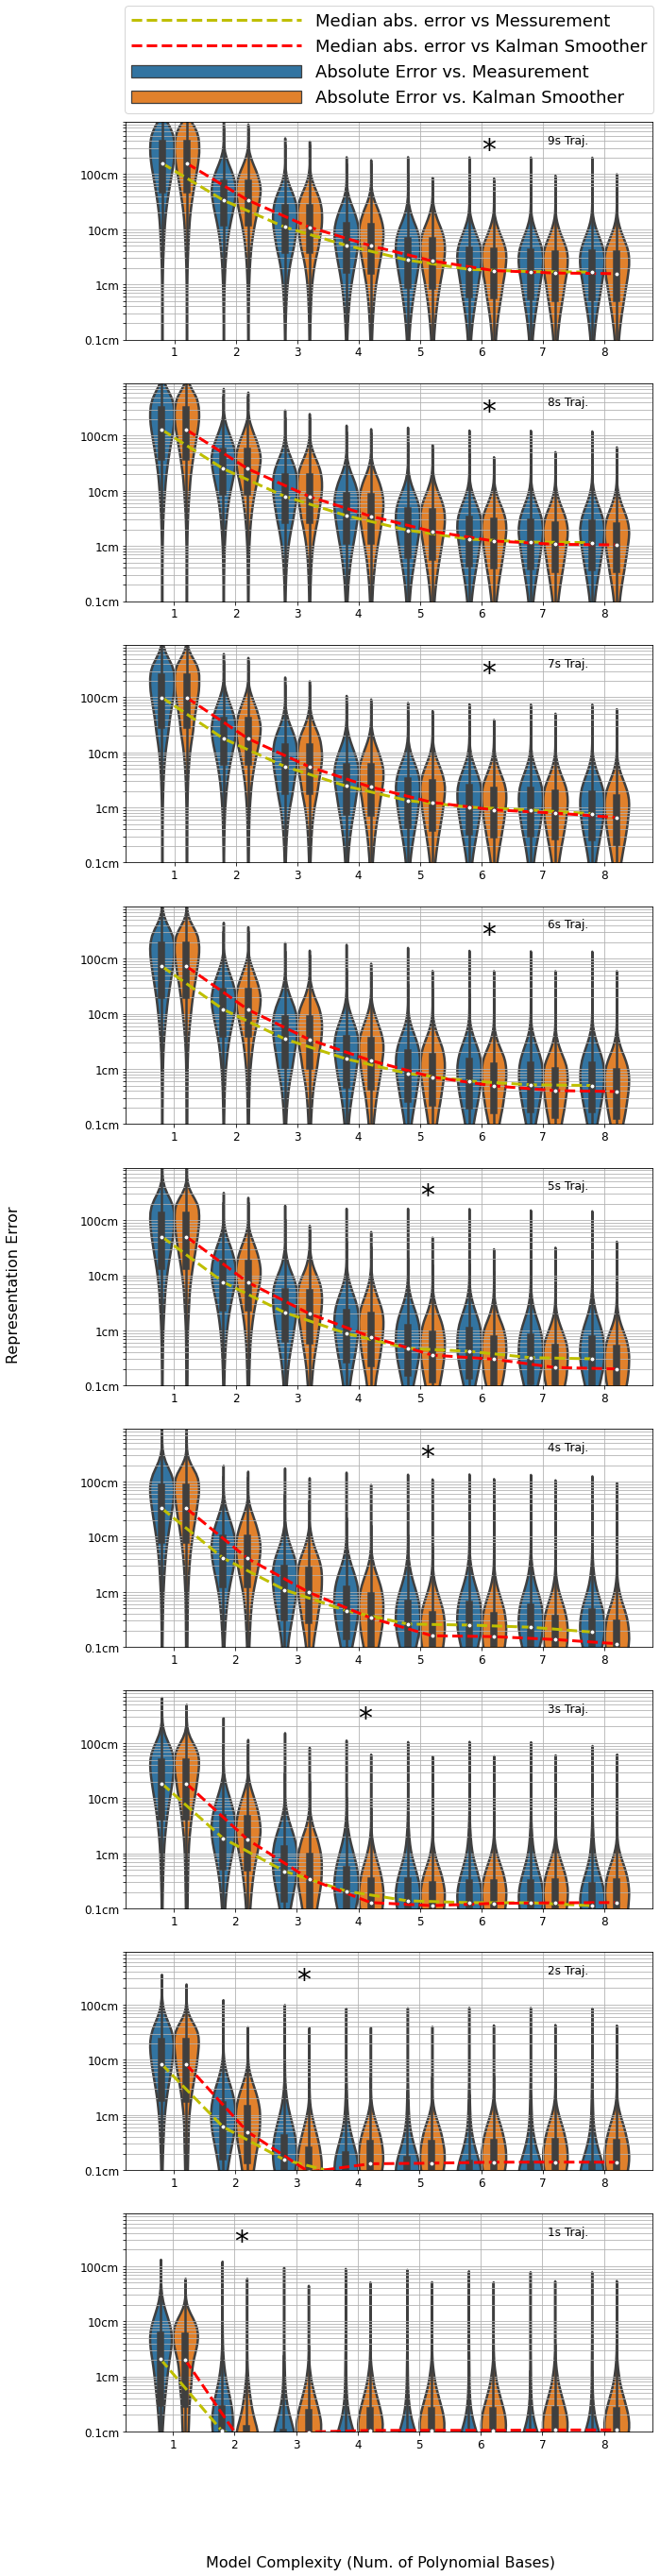

In [26]:
data_name_1 = 'gt_poly'
data_name_2 = 'kf_poly'
fig_name = 'Longitudinal Positional Fitting Error Compared to Measurement/Kalman Smoother (ego)'
nums_points_in_one_traj = [91, 81, 71, 61, 51, 41, 31, 21, 11]
x_ticklabels = ['1', '2', '3', '4', '5', '6', '7', '8']

tick_range = [x for p in [-4, -3, -2, -1, 0] for x in np.linspace(10 ** p, 9 * 10 ** p, 9)]

y_ticklabels = []
for p in ['0.01cm', '0.1cm', '1cm', '10cm', '100cm']:
    for i in range(9):
        if i == 0:
            y_ticklabels.append(p)
        else:
            y_ticklabels.append('')

fig1, axs = plt.subplots(len(nums_points_in_one_traj), 1, figsize = (10, 45))
#fig1.suptitle(fig_name, y=0.92)
fig1.supxlabel('Model Complexity (Num. of Polynomial Bases)', y=0.08)
fig1.supylabel('Representation Error', x = -0.05)
for idx, num_points in enumerate(tqdm(nums_points_in_one_traj)):
    ax = axs[idx]
    with open('results/ego_pos_error/' + str(num_points) + '/' + str(data_name_1) + '_lon' + '.json', "r") as read_file:
        data_gt = np.array(json.load(read_file)) # keep it as list for visualization
        data_gt = np.log10(data_gt[:, ::30]+ 1e-10).reshape(8, -1)
        
    with open('results/ego_pos_error/' + str(num_points) + '/' + str(data_name_2) + '_lon' + '.json', "r") as read_file:
        data_kf = np.array(json.load(read_file)) # keep it as list for visualization
        data_kf = np.log10(data_kf[:, ::30]+ 1e-10).reshape(8, -1)
    
    d = {'deg': [], 'error': [], 'type': []}
    
    for deg, (d1, d2) in enumerate(zip(data_gt, data_kf)):
        for dd1, dd2 in zip(d1, d2):
            d['deg'].append(deg+1)
            d['error'].append(dd1)
            d['type'].append('Absolute Error vs. Measurement')
            
            d['deg'].append(deg+1)
            d['error'].append(dd2)
            d['type'].append('Absolute Error vs. Kalman Smoother')
    test_data = pd.DataFrame(data=d)
    
    with open('logs/gradient_tape/ego_xy' + str(num_points) + '/result_summary.json')as read_file:
        result = json.load(read_file)
    print('finish loading')
    
    
    best_AIC_idx = result['best_aic_deg_idx']
    x_ticklabels_with_best_AIC = deepcopy(x_ticklabels)
    x_ticklabels_with_best_AIC[best_AIC_idx] = x_ticklabels_with_best_AIC[best_AIC_idx] + '*'
    ax = sns.violinplot(x = test_data.deg, y = test_data.error,  hue=test_data.type, data = test_data, ax=ax, linewidth = 2.5)
    ax.plot(np.array(range(8)) - 0.2, np.median(data_gt,axis = 1), 'y--' , linewidth = 3, label = 'Median abs. error vs Messurement')
    ax.plot(np.array(range(8)) + 0.2, np.median(data_kf,axis = 1), 'r--' , linewidth = 3, label = 'Median abs. error vs Kalman Smoother')
    
    
    if idx == 0:
        ax.legend(fontsize = 18, loc='lower center', bbox_to_anchor=(0.5, 1), handlelength= 10)
    else:
        ax.get_legend().remove()
    
    ax.annotate(str(int(num_points/10)) + 's Traj.',
            xy = (0.8, 0.9),
            xycoords='axes fraction')
    #ax.annotate('*', fontsize= 30, color = current_palette[best_AIC_idx], xy = (best_AIC_idx, 0.3))
    ax.annotate('*', fontsize= 30, xy = (best_AIC_idx, 0.3))
    ax.set_xticklabels(x_ticklabels)
    ax.set_xlabel('')
    ax.set_ylim([np.log10(1e-4), np.log10(1e0)])
    ax.set_ylabel('')
    #ax.set_yscale('log')
    #ax.set_yticklabels(['', '1mm', '1cm', '0.1m', '1m'])
    ax.set_yticks(np.log10(tick_range))
    ax.set_yticklabels(y_ticklabels)
    ax.grid(True)
    ax.plot()

In [31]:
fig1.savefig('imgs/ego_error_lon_waymo.svg', dpi=300, format='svg', bbox_inches='tight')
fig1.savefig('imgs/ego_error_lon_waymo.pdf', dpi=300, format='pdf', bbox_inches='tight')

# Evaluation 3: Evaluate AIC and BIC (agt)

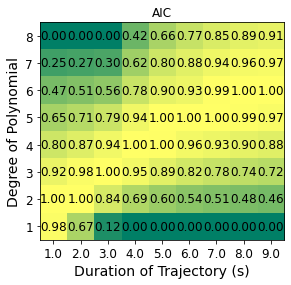

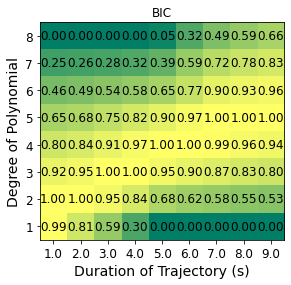

In [6]:
# Visualise AIC, BIC
object_type = 'cyclist'
num_of_points_list = [11, 21, 31, 41, 51, 61, 71, 81, 91]
degrees = [1, 2, 3, 4, 5, 6, 7, 8]
AIC_matrix = np.zeros((8, len(num_of_points_list)))
BIC_matrix = np.zeros((8, len(num_of_points_list)))
fig, ax = plt.subplots()
fig2, ax2 = plt.subplots()
cmap = mpl.cm.summer
for idx, num_of_points in enumerate(num_of_points_list):
    folder_dir = 'logs/gradient_tape/' + object_type + '/agt_xy_polar_plus_const_' + str(num_of_points)
    file_name = 'result_summary'
    with open(folder_dir + '/' + file_name + '.json', "r") as read_file:
        result = json.load(read_file)
    AIC_score = np.array(result['aic_scores'])

    AIC_score = -AIC_score # reverse the score, so that the higher the better
    AIC_score_norm = (AIC_score - np.amin(AIC_score))/(np.amax(AIC_score) - np.amin(AIC_score))
    AIC_matrix[:, idx] = AIC_score_norm[::-1]
    
    BIC_score = np.array(result['bic_scores'])

    BIC_score = -BIC_score # reverse the score, so that the higher the better
    BIC_score_norm = (BIC_score - np.amin(BIC_score))/(np.amax(BIC_score) - np.amin(BIC_score))
    BIC_matrix[:, idx] = BIC_score_norm[::-1]


ax.imshow(AIC_matrix, cmap = cmap)
for (i, j), z in np.ndenumerate(AIC_matrix):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')

ax.set_xticks(np.arange(0, AIC_matrix.shape[1], 1));
ax.set_yticks(np.arange(0, AIC_matrix.shape[0], 1));
ax.set_xticklabels((np.array(num_of_points_list)-1) / 10);
ax.set_yticklabels(degrees[::-1]);


ax2.imshow(BIC_matrix, cmap = cmap)
for (i, j), z in np.ndenumerate(BIC_matrix):
    ax2.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')

ax2.set_xticks(np.arange(0, BIC_matrix.shape[1], 1));
ax2.set_yticks(np.arange(0, BIC_matrix.shape[0], 1));
ax2.set_xticklabels((np.array(num_of_points_list)-1) / 10);
ax2.set_yticklabels(degrees[::-1]);

#ax.set_title('Normalized avg. AIC (higher value is better)')
ax.set_title('AIC')
ax.set_ylabel('Degree of Polynomial')
ax.set_xlabel('Duration of Trajectory (s)')

fig.show()
fig.savefig('imgs/Argoverse 2 Normalized AIC related to the Duration of Trajectory (agt ' + object_type + ').pdf', dpi = 300)

#ax2.set_title('Normalized avg. BIC (higher value is better)')
ax2.set_title('BIC')
ax2.set_ylabel('Degree of Polynomial')
ax2.set_xlabel('Duration of Trajectory (s)')

fig2.show()
fig2.savefig('imgs/Argoverse 2 Normalized BIC related to the Duration of Trajectory (agt ' + object_type + ').pdf', dpi = 300)

# Evaluation 4: Analyse Fitting Error (agt)

In [16]:
BATCH_SIZE = 1024

object_type = 'cyclist'
num_points_in_one_traj = 51

In [17]:
# Load results
#prior_folder_dir = 'logs/gradient_tape/' + object_type + '/agt_xy_polar_plus_const_' + str(num_points_in_one_traj)
prior_folder_dir = 'logs/gradient_tape/' + object_type + '/agt_' + str(num_points_in_one_traj) + '_track'
file_name = 'result_summary'

# Load prior parameters
with open(prior_folder_dir + '/' + file_name + '.json', "r") as read_file:
    result = json.load(read_file)

if object_type == 'vehicle':
    with open("data/"+ object_type + "/agt_trajs_" + str(num_points_in_one_traj) + "_json/agt_trajs_select_non_outlier_indicies.json", "r") as read_file:
        idx_trajs_select = json.load(read_file)

    list_dataset = dataloader_utils.generate_selected_file_list_dataset('data'+ object_type + '/agt_trajs_json/', idx_trajs_select)
    start_idx_dataset = dataloader_utils.generate_selected_start_indicies_dataset("data/"+ object_type + "agt_trajs_" + str(num_points_in_one_traj) + "_json_new/agt_trajs_start_point_indicies.json")
else:
    with open("data/"+ object_type + "/agt_trajs_" + str(num_points_in_one_traj) + "_json/agt_trajs_outlier_indicies.json", "r") as read_file:
        idx_outlier = json.load(read_file)
        
    list_dataset = dataloader_utils.generate_file_list_dataset('data/'+ object_type + '/agt_trajs_json/', idx_outlier)
    start_idx_dataset = dataloader_utils.generate_start_indicies_dataset("data/"+ object_type + "/agt_trajs_" + str(num_points_in_one_traj) + "_json/agt_trajs_start_point_indicies.json", idx_outlier)
        
combined_dataset = tf.data.Dataset.zip((list_dataset, start_idx_dataset))

dataProcessor = dataloader_utils.DataProcessor(BATCH_SIZE, combined_dataset, num_points_in_one_traj, traj_type='agt_traj', with_heading=True)
dataProcessor.load_process(shuffle = False)

print(dataProcessor.loaded_dataset.__len__())

100%|██████████| 62785/62785 [00:13<00:00, 4743.53it/s]


tf.Tensor(46, shape=(), dtype=int64)


In [8]:
def preprocess_smoothed_trajs(trajs_smooth, idx_invalid):
    idx_valid = list(set(range(trajs_smooth.shape[0])) - set(idx_invalid))
    trajs_smooth = trajs_smooth[idx_valid]
            
    return trajs_smooth


with open("data/" + object_type + "/agt_trajs_" + str(num_points_in_one_traj) + "_json/agt_trajs_filtered_CA.json", "r") as read_file:
    agt_smoothed_traj = np.array(json.load(read_file))[:, :, [0,3]] 


In [9]:
if object_type == 'vehicle':
    smoothed_traj_dataset = tf.data.Dataset.from_tensor_slices(agt_smoothed_traj)
else:
    smoothed_traj_dataset = tf.data.Dataset.from_tensor_slices(preprocess_smoothed_trajs(agt_smoothed_traj, idx_outlier))
                                                               
smoothed_traj_dataset = smoothed_traj_dataset.batch(BATCH_SIZE)
print(smoothed_traj_dataset.__len__())  

tf.Tensor(46, shape=(), dtype=int64)


In [27]:
degrees = result['degree']

errors_gt_poly_lon = np.zeros((len(degrees), start_idx_dataset.__len__(),  num_points_in_one_traj))
errors_gt_poly_lat = np.zeros((len(degrees), start_idx_dataset.__len__(), num_points_in_one_traj))

errors_kf_poly_lon = np.zeros((len(degrees), start_idx_dataset.__len__(), num_points_in_one_traj))
errors_kf_poly_lat = np.zeros((len(degrees), start_idx_dataset.__len__(), num_points_in_one_traj))

errors_gt_kf_lon = np.zeros((start_idx_dataset.__len__(), num_points_in_one_traj))
errors_gt_kf_lat = np.zeros((start_idx_dataset.__len__(), num_points_in_one_traj))

poly_fit = np.zeros((len(degrees), start_idx_dataset.__len__(), num_points_in_one_traj* 2))

ob_error = np.zeros((start_idx_dataset.__len__(), num_points_in_one_traj))

for idx_deg, deg in enumerate(tqdm(degrees)):
    current_batch_idx = 0
    print('Processing deg: ', deg)
    
    for (t_samples, mess_traj_samples, heading_samples, d_norm_samples, theta_samples, R_samples), ks_traj_samples in zip(dataProcessor.loaded_dataset, smoothed_traj_dataset):
        next_batch_idx = current_batch_idx + mess_traj_samples.shape[0]
        t_samples = t_samples.numpy()
        mess_traj_samples = mess_traj_samples.numpy()
        heading_samples = heading_samples.numpy()
        d_norm_samples = d_norm_samples.numpy()
        theta_samples = theta_samples.numpy()
        R_samples = R_samples.numpy()
        R_samples = np.transpose(R_samples, (0, 2, 3, 1))
        ks_traj_samples = ks_traj_samples.numpy()
        ks_traj_samples =  np.concatenate((ks_traj_samples[:, :, 0], ks_traj_samples[:, :, 1]), axis = 1)
        
        heading_norm_samples = heading_samples[:, :, [1,0]] 
        heading_norm_samples[:, :, 0] = -heading_norm_samples[:, :, 0]
        
        phi_t_batch = utils.expand(t_samples, bf=utils.polynomial_basis_function, bf_args=range(1, deg+1)).transpose((1, 0, 2))
        phi_t_kron = np.kron(np.eye(2), phi_t_batch[:, :, 1:])
        
        phi_d = utils.expand(d_norm_samples, bf=utils.polynomial_basis_function, bf_args=range(1, 2+1)).transpose((1, 0, 2))

        A = np.array(result['A_list'][deg-1])
        b_d = np.squeeze(np.array(result['B_list'][deg-1]['B_d']))
        b_theta = np.squeeze(np.array(result['B_list'][deg-1]['B_theta']))
        b_const = np.squeeze(np.array(result['B_list'][deg-1]['B_const']))

        R = np.block([[tf.linalg.diag(R_samples[:, 0, 0]), tf.linalg.diag(R_samples[:, 0, 1])],
                      [tf.linalg.diag(R_samples[:, 1, 0]), tf.linalg.diag(R_samples[:, 1, 1])]])
        
        var_d = np.squeeze(phi_d @ b_d)
        var_theta =  b_theta
        theta_cos = tf.math.cos(theta_samples)
        theta_sin = tf.math.sin(theta_samples)
        d_pow =  tf.math.pow(d_norm_samples, 2)
        var_lon_lon = var_d * tf.math.pow(theta_cos, 2) + var_theta *  d_pow * tf.math.pow(theta_sin, 2)
        var_lat_lat = var_d * tf.math.pow(theta_sin, 2) + var_theta *  d_pow * tf.math.pow(theta_cos, 2)
        var_lon_lat = var_d * theta_sin * theta_cos - var_theta *  d_pow * theta_sin * theta_cos 
        
        by_eye = np.array([[0,1],[1,0]])
        b_lon_lat_by_diag = np.kron(by_eye, tf.linalg.diag(var_lon_lat))
        
        b_lon_lat_diag = tf.linalg.diag(tf.concat([var_lon_lon + b_const, var_lat_lat + b_const], axis = 1)).numpy()
        b_lon_lat = b_lon_lat_diag + b_lon_lat_by_diag
        
        # mvn = tfd.MultivariateNormalFullCovariance(loc=np.zeros((2* num_points_in_one_traj)), covariance_matrix=b_lon_lat)
        # samples = mvn.sample()
        # samples = np.concatenate([samples[:, :num_points_in_one_traj, np.newaxis], samples[:, num_points_in_one_traj:, np.newaxis]], axis=2)
        # ob_error[current_batch_idx: next_batch_idx] = np.linalg.norm(samples, axis = 2)   
        
        B   = R @ b_lon_lat @ np.transpose(R, (0, 2, 1))

        
        phi_T_sigma_o = np.transpose(np.linalg.solve(B, phi_t_kron), (0,2,1))
        sigma_post_inv = np.linalg.inv(A) + phi_T_sigma_o @ phi_t_kron
        mu_N = np.linalg.solve(sigma_post_inv, phi_T_sigma_o) @ mess_traj_samples[:, :, None]
    
        pred = (phi_t_kron @ mu_N )[:, :, 0]
        
        error_gt_poly_x = mess_traj_samples[:, :num_points_in_one_traj] - pred[:, :num_points_in_one_traj]
        error_gt_poly_y = mess_traj_samples[:, num_points_in_one_traj:] - pred[:, num_points_in_one_traj:]
        error_gt_poly_lon, error_gt_poly_lat, _ = utils.project_error(error_gt_poly_x, error_gt_poly_y, heading_samples, heading_norm_samples, return_abs = True)
        errors_gt_poly_lon[idx_deg, current_batch_idx: next_batch_idx] = error_gt_poly_lon
        errors_gt_poly_lat[idx_deg, current_batch_idx: next_batch_idx] = error_gt_poly_lat

        error_kf_poly_x = ks_traj_samples[:, :num_points_in_one_traj] - pred[:, :num_points_in_one_traj]
        error_kf_poly_y = ks_traj_samples[:, num_points_in_one_traj:] - pred[:, num_points_in_one_traj:]
        error_kf_poly_lon, error_kf_poly_lat, _ = utils.project_error(error_kf_poly_x, error_kf_poly_y, heading_samples, heading_norm_samples, return_abs = True)
        errors_kf_poly_lon[idx_deg, current_batch_idx: next_batch_idx] = error_kf_poly_lon
        errors_kf_poly_lat[idx_deg, current_batch_idx: next_batch_idx] = error_kf_poly_lat
        
        
        error_x_gt_kf = mess_traj_samples[:, :num_points_in_one_traj] - ks_traj_samples[:, :num_points_in_one_traj]
        error_y_gt_kf = mess_traj_samples[:, num_points_in_one_traj:] - ks_traj_samples[:, num_points_in_one_traj:]
        error_gt_kf_lon, error_gt_kf_lat, _ = utils.project_error(error_x_gt_kf, error_y_gt_kf, heading_samples, heading_norm_samples, return_abs = True)
        errors_gt_kf_lon[current_batch_idx: next_batch_idx] = error_gt_kf_lon
        errors_gt_kf_lat[current_batch_idx: next_batch_idx] = error_gt_kf_lat
        

        current_batch_idx = next_batch_idx

print('finished')      

  0%|          | 0/8 [00:00<?, ?it/s]

Processing deg:  1


 12%|█▎        | 1/8 [08:24<58:51, 504.49s/it]

Processing deg:  2


 25%|██▌       | 2/8 [13:46<39:43, 397.28s/it]

Processing deg:  3


 38%|███▊      | 3/8 [19:09<30:15, 363.05s/it]

Processing deg:  4


 50%|█████     | 4/8 [24:31<23:08, 347.05s/it]

Processing deg:  5


 62%|██████▎   | 5/8 [29:53<16:54, 338.10s/it]

Processing deg:  6


 75%|███████▌  | 6/8 [35:16<11:05, 332.74s/it]

Processing deg:  7


 88%|████████▊ | 7/8 [40:38<05:29, 329.34s/it]

Processing deg:  8


100%|██████████| 8/8 [47:00<00:00, 352.59s/it]

finished


In [ ]:
summary_lon = {'attributes': ['mean', 'median', '99.9% percentile', 'max', 'min']}

summary_temp = []
print('Error in longitudinal')
print('Mess vs Poly')    
for idx, deg in enumerate(degrees):
    error = errors_gt_poly_lon[idx]
    print('Deg: %.0f, Mean: %.5f, Median: %.5f, 99.9%% Percentil: %.5f, Max: %.5f; Min: %.5f' %(deg, np.mean(error), np.median(error), np.percentile(error.reshape((-1)), [99.9]), np.max(error), np.min(error)))
    summary_temp.append([np.mean(error), np.median(error), np.percentile(error.reshape((-1)), 99.9), np.max(error), np.min(error)])
summary_lon['gt_poly'] = summary_temp
    
    
summary_temp = []
print('\n')
print('KF vs Poly')
for idx, deg in enumerate(degrees):
    error = errors_kf_poly_lon[idx]
    print('Deg: %.0f, Mean: %.5f, Median: %.5f, 99.9%% Percentil: %.5f, Max: %.5f; Min: %.5f' %(deg, np.mean(error), np.median(error), np.percentile(error.reshape((-1)), [99.9]), np.max(error), np.min(error)))
    summary_temp.append([np.mean(error), np.median(error), np.percentile(error.reshape((-1)), 99.9), np.max(error), np.min(error)])
summary_lon['kf_poly'] = summary_temp
    
summary_temp = []
print('\n')
print('KF vs Mess')
print('Mean: %.5f, Median: %.5f, 99.9%% Percentil: %.5f, Max: %.5f; Min: %.5f' %(np.mean(errors_gt_kf_lon), np.median(errors_gt_kf_lon), np.percentile(errors_gt_kf_lon.reshape((-1)), [99.9]), np.max(errors_gt_kf_lon), np.min(errors_gt_kf_lon)))
summary_lon['gt_kf'] = [np.mean(errors_gt_kf_lon), np.median(errors_gt_kf_lon), np.percentile(errors_gt_kf_lon.reshape((-1)), 99.9), np.max(errors_gt_kf_lon), np.min(errors_gt_kf_lon)]

Error in longitudinal
Mess vs Poly
Deg: 1, Mean: 0.32893, Median: 0.17955, 99.9% Percentil: 3.06031, Max: 7.88650; Min: 0.00000
Deg: 2, Mean: 0.07110, Median: 0.04393, 99.9% Percentil: 0.65270, Max: 1.69551; Min: 0.00000
Deg: 3, Mean: 0.03816, Median: 0.02629, 99.9% Percentil: 0.30395, Max: 0.91049; Min: 0.00000
Deg: 4, Mean: 0.02903, Median: 0.02068, 99.9% Percentil: 0.21200, Max: 0.79817; Min: 0.00000
Deg: 5, Mean: 0.02493, Median: 0.01793, 99.9% Percentil: 0.17751, Max: 0.76396; Min: 0.00000
Deg: 6, Mean: 0.02443, Median: 0.01759, 99.9% Percentil: 0.17436, Max: 0.76222; Min: 0.00000
Deg: 7, Mean: 0.02273, Median: 0.01633, 99.9% Percentil: 0.16593, Max: 0.73523; Min: 0.00000
Deg: 8, Mean: 0.02260, Median: 0.01624, 99.9% Percentil: 0.16496, Max: 0.74018; Min: 0.00000


KF vs Poly
Deg: 1, Mean: 0.32696, Median: 0.17698, 99.9% Percentil: 3.06216, Max: 7.95890; Min: 0.00000
Deg: 2, Mean: 0.06467, Median: 0.03609, 99.9% Percentil: 0.64517, Max: 1.67050; Min: 0.00000
Deg: 3, Mean: 0.02756,

In [ ]:
summary_lat = {'attributes': ['mean', 'median', '99.9% percentile', 'max', 'min']}

summary_temp = []
print('Error in lateral')
print('Mess vs Poly')    
for idx, deg in enumerate(degrees):
    error = errors_gt_poly_lat[idx]
    print('Deg: %.0f, Mean: %.5f, Median: %.5f, 99.9%% Percentil: %.5f, Max: %.5f; Min: %.5f' %(deg, np.mean(error), np.median(error), np.percentile(error.reshape((-1)), [99.9]), np.max(error), np.min(error)))
    summary_temp.append([np.mean(error), np.median(error), np.percentile(error.reshape((-1)), 99.9), np.max(error), np.min(error)])
summary_lat['gt_poly'] = summary_temp

summary_temp = []
print('\n')
print('KF vs Poly')
for idx, deg in enumerate(degrees):
    error = errors_kf_poly_lat[idx]
    print('Deg: %.0f, Mean: %.5f, Median: %.5f, 99.9%% Percentil: %.5f, Max: %.5f; Min: %.5f' %(deg, np.mean(error), np.median(error), np.percentile(error.reshape((-1)), [99.9]), np.max(error), np.min(error)))
    summary_temp.append([np.mean(error), np.median(error), np.percentile(error.reshape((-1)), 99.9), np.max(error), np.min(error)])
summary_lat['kf_poly'] = summary_temp
    
summary_temp = []
print('\n')
print('KF vs Mess')
print('Mean: %.5f, Median: %.5f, 99.9%% Percentil: %.5f, Max: %.5f; Min: %.5f' %(np.mean(errors_gt_kf_lat), np.median(errors_gt_kf_lat), np.percentile(errors_gt_kf_lat.reshape((-1)), [99.9]), np.max(errors_gt_kf_lat), np.min(errors_gt_kf_lat)))
summary_lat['gt_kf'] = [np.mean(errors_gt_kf_lat), np.median(errors_gt_kf_lat), np.percentile(errors_gt_kf_lat.reshape((-1)), 99.9), np.max(errors_gt_kf_lat), np.min(errors_gt_kf_lat)]

Error in lateral
Mess vs Poly
Deg: 1, Mean: 0.26354, Median: 0.11539, 99.9% Percentil: 3.39574, Max: 7.67183; Min: 0.00000
Deg: 2, Mean: 0.08437, Median: 0.04771, 99.9% Percentil: 0.94254, Max: 2.43371; Min: 0.00000
Deg: 3, Mean: 0.03904, Median: 0.02544, 99.9% Percentil: 0.38992, Max: 1.13257; Min: 0.00000
Deg: 4, Mean: 0.02276, Median: 0.01618, 99.9% Percentil: 0.19657, Max: 0.55603; Min: 0.00000
Deg: 5, Mean: 0.01572, Median: 0.01176, 99.9% Percentil: 0.11640, Max: 0.31761; Min: 0.00000
Deg: 6, Mean: 0.01437, Median: 0.01086, 99.9% Percentil: 0.10146, Max: 0.31465; Min: 0.00000
Deg: 7, Mean: 0.01225, Median: 0.00934, 99.9% Percentil: 0.08293, Max: 0.31081; Min: 0.00000
Deg: 8, Mean: 0.01221, Median: 0.00932, 99.9% Percentil: 0.08249, Max: 0.31288; Min: 0.00000


KF vs Poly
Deg: 1, Mean: 0.26245, Median: 0.11408, 99.9% Percentil: 3.39007, Max: 7.70937; Min: 0.00000
Deg: 2, Mean: 0.08184, Median: 0.04493, 99.9% Percentil: 0.92818, Max: 2.44689; Min: 0.00000
Deg: 3, Mean: 0.03452, Medi

In [ ]:
PATH = 'results/agt_pos_error_polar_waymo/' + object_type + '/' + str(num_points_in_one_traj) + '_track'
if not os.path.exists(PATH):
    os.makedirs(PATH)

with open(PATH + '/gt_poly_lon' + '.json', "w") as write_file:
    json.dump(errors_gt_poly_lon, write_file, cls=utils.NumpyEncoder)
    
with open(PATH + '/gt_poly_lat' + '.json', "w") as write_file:
    json.dump(errors_gt_poly_lat, write_file, cls=utils.NumpyEncoder)
    
with open(PATH + '/kf_poly_lon' + '.json', "w") as write_file:
    json.dump(errors_kf_poly_lon, write_file, cls=utils.NumpyEncoder)
    
with open(PATH + '/kf_poly_lat' + '.json', "w") as write_file:
    json.dump(errors_kf_poly_lat, write_file, cls=utils.NumpyEncoder)
    
with open(PATH + '/gt_kf_lon' + '.json', "w") as write_file:
    json.dump(errors_gt_kf_lon, write_file, cls=utils.NumpyEncoder)
    
with open(PATH + '/gt_kf_lat' + '.json', "w") as write_file:
    json.dump(errors_gt_kf_lat, write_file, cls=utils.NumpyEncoder)

In [31]:
with open(PATH + '/summary_lon' + '.json', "w") as write_file:
    json.dump(summary_lon, write_file, cls=utils.NumpyEncoder)
    
with open(PATH + '/summary_lat' + '.json', "w") as write_file:
    json.dump(summary_lat, write_file, cls=utils.NumpyEncoder)

# Dummy Code (Visualize trajectories with big representation error)

In [9]:
num_points_in_one_traj = 81
object_type = 'pedestrain' #
BATCH_SIZE = 1024
with open('results/agt_pos_error_polar_' + 'waymo'+ '/' + object_type + '/' + str(num_points_in_one_traj) + '/' + 'gt_kf_lat' + '.json', "r") as read_file:
    data_1 = np.array(json.load(read_file)) # keep it as list for visualization

test_idx = np.argwhere(data_1 >0.7)
test_idx

array([[  5563,     66],
       [  5563,     70],
       [  9907,     41],
       [ 17183,      2],
       [ 23037,      1],
       [ 39136,     47],
       [ 39136,     51],
       [ 39136,     62],
       [ 41521,      8],
       [ 55860,     57],
       [ 89295,      5],
       [ 98767,      6],
       [126698,     26]])

In [10]:
# Choose the first outlier trajectory and first outlier point in it.
outlier_traj_idx = test_idx[0,0]
outlier_pt_idx = test_idx[0,1]

In [11]:
if object_type == 'vehicle':
    with open('data/' + object_type + '/agt_trajs_' + str(num_points_in_one_traj) + '_json/agt_trajs_select_non_outlier_indicies.json', "r") as read_file:
        idx_trajs_select = json.load(read_file)

    list_dataset = dataloader_utils.generate_selected_file_list_dataset('data/' + object_type + '/agt_trajs_json/', idx_trajs_select)
    start_idx_dataset = dataloader_utils.generate_selected_start_indicies_dataset('data/' + object_type + '/agt_trajs_' + str(num_points_in_one_traj) + '_json/agt_trajs_start_point_indicies.json')
    combined_dataset = tf.data.Dataset.zip((list_dataset, start_idx_dataset))
else:
    with open('data/' + object_type + '/agt_trajs_' + str(num_points_in_one_traj) + '_json/agt_trajs_outlier_indicies.json', "r") as read_file:
        idx_outlier = json.load(read_file)
        
    list_dataset = dataloader_utils.generate_file_list_dataset('data/' + object_type + '/agt_trajs_json/', idx_outlier)
    start_idx_dataset = dataloader_utils.generate_start_indicies_dataset('data/' + object_type + '/agt_trajs_' + str(num_points_in_one_traj) + '_json/agt_trajs_start_point_indicies.json', idx_outlier)

combined_dataset = tf.data.Dataset.zip((list_dataset, start_idx_dataset))

dataProcessor = dataloader_utils.DataProcessor(BATCH_SIZE, combined_dataset, num_points_in_one_traj, traj_type = 'agt_traj')
dataProcessor.load_process(shuffle = False)

print(dataProcessor.loaded_dataset.__len__())

100%|██████████| 231508/231508 [03:27<00:00, 1113.84it/s]
2022-11-01 09:07:25.824898: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
100%|██████████| 231508/231508 [03:29<00:00, 1105.07it/s]


tf.Tensor(126, shape=(), dtype=int64)


In [13]:
start_idx = 0

interested_traj = None
for _, agt_traj, _, _, _ in dataProcessor.loaded_dataset:
    batch_size = agt_traj.shape[0]
    
    if start_idx + batch_size >= outlier_traj_idx and start_idx < outlier_traj_idx:
        print('found')

        interested_traj = agt_traj[outlier_traj_idx- start_idx]
        break
    
    start_idx = start_idx+batch_size

found


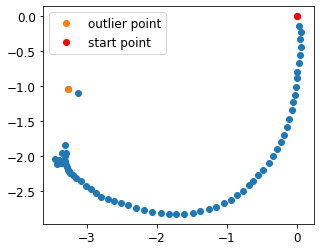

In [16]:
# Plot the point in trajectory with big representation error
fig, ax = plt.subplots()
ax.plot(interested_traj[:num_points_in_one_traj], interested_traj[num_points_in_one_traj:], 'o')
ax.plot(interested_traj[outlier_pt_idx], interested_traj[outlier_pt_idx+num_points_in_one_traj], 'o', label='outlier point')
ax.plot(interested_traj[0], interested_traj[num_points_in_one_traj], 'ro', label = 'start point')
ax.set_aspect('equal')
ax.legend()
#fig.savefig('imgs/waymo_pedestrain_lat_outlier_2.jpg', dpi=200)

# Dummy Code 2 (Naive baseline prediction)

In [3]:
def prior_with_pos(pos_cov, prior):
    deg = int(prior.shape[0] /2)
    prior_with_pos=np.zeros((prior.shape[0]+2, prior.shape[0]+2))
    
    prior_with_pos[1:deg+1, 1:deg+1] = prior[0:deg, 0:deg]
    prior_with_pos[deg+2:2*deg+2, deg+2:2*deg+2] = prior[deg:2*deg, deg:2*deg]
    prior_with_pos[1:deg+1, deg+2:2*deg+2] = prior[0:deg, deg:2*deg]
    prior_with_pos[deg+2:2*deg+2, 1:deg+1] = prior[deg:2*deg, 0:deg]
    prior_with_pos[0,0] = pos_cov[0,0]
    prior_with_pos[0,deg+1] = pos_cov[0,1]
    prior_with_pos[deg+1,0] = pos_cov[1,0]
    prior_with_pos[deg+1, deg+1] = pos_cov[1,1]
    
    return prior_with_pos

In [8]:
BATCH_SIZE = 1024
k = 1
hist_length = 10

object_type = 'vehicle'
num_points_in_one_traj = 91 # 5s trajectory, 2s as past, 3s as future. Comparable to Argoverse 1
with_outlier = False

In [5]:
# Load results
prior_folder_dir = 'logs/gradient_tape/' + object_type + '/agt_xy_polar_plus_const_' + str(num_points_in_one_traj)
file_name = 'result_summary'


# Load prior parameters
with open(prior_folder_dir + '/' + file_name + '.json', "r") as read_file:
    prior = json.load(read_file)

if object_type == 'vehicle':
    if with_outlier:
        idx_trajs_select = list(np.sort(np.random.choice(range(1829161), size=300000, replace=False)))
        list_dataset = dataloader_utils.generate_selected_file_list_dataset('data/'+ object_type + '/agt_trajs_json/', idx_trajs_select)
        start_idx_dataset = tf.data.Dataset.from_tensor_slices((np.ones(list_dataset.__len__(), dtype = np.int16)*10)) # all start from 10-th point
    else:
        with open("data/"+ object_type + "/agt_trajs_" + str(num_points_in_one_traj) + "_json/agt_trajs_select_non_outlier_indicies.json", "r") as read_file:
            idx_trajs_select = json.load(read_file)
            
        list_dataset = dataloader_utils.generate_selected_file_list_dataset('data/'+ object_type + '/agt_trajs_json/', idx_trajs_select)
        start_idx_dataset = tf.data.Dataset.from_tensor_slices((np.zeros(list_dataset.__len__(), dtype = np.int16))) # all start from 10-th point
        #start_idx_dataset = dataloader_utils.generate_selected_start_indicies_dataset("data/"+ object_type + "/agt_trajs_" + str(num_points_in_one_traj) + "_json/agt_trajs_start_point_indicies.json")
else:
    if with_outlier:
        list_dataset = dataloader_utils.generate_file_list_dataset('data/'+ object_type + '/agt_trajs_json/', [])
        start_idx_dataset = tf.data.Dataset.from_tensor_slices((np.ones(list_dataset.__len__(), dtype = np.int16)*10)) # all start from 10-th point
    else:
        with open("data/"+ object_type + "/agt_trajs_" + str(num_points_in_one_traj) + "_json/agt_trajs_outlier_indicies.json", "r") as read_file:
            idx_outlier = json.load(read_file)

        list_dataset = dataloader_utils.generate_file_list_dataset('data/'+ object_type + '/agt_trajs_json/', idx_outlier)
        start_idx_dataset = dataloader_utils.generate_start_indicies_dataset("data/"+ object_type + "/agt_trajs_" + str(num_points_in_one_traj) + "_json/agt_trajs_start_point_indicies.json", idx_outlier)

combined_dataset = tf.data.Dataset.zip((list_dataset, start_idx_dataset))

dataProcessor = dataloader_utils.DataProcessor(BATCH_SIZE, combined_dataset, num_points_in_one_traj, traj_type='agt_traj', with_heading=True)
dataProcessor.load_process(shuffle = False)

print(dataProcessor.loaded_dataset.__len__())

100%|██████████| 300000/300000 [00:00<00:00, 364157.48it/s]
2022-11-01 19:52:39.565081: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


tf.Tensor(293, shape=(), dtype=int64)


In [22]:
deg = 8
A = np.array(prior['A_list'][deg-1])
B_d = np.array(prior['B_list'][deg-1]['B_d'])
B_theta = np.array(prior['B_list'][deg-1]['B_theta'])
B_const = np.array(prior['B_list'][deg-1]['B_const'])

In [23]:
current_batch_idx = 0
preds = np.zeros((list_dataset.__len__(), k, num_points_in_one_traj, 2))
gt = np.zeros((list_dataset.__len__(), num_points_in_one_traj, 2))
probs = np.zeros((list_dataset.__len__(), k))
probs[:, 0] = 0.5
probs[:, 1:] = 0.1
for t_samples, traj_samples, _, d_norm_samples, theta_samples, R_samples in tqdm(dataProcessor.loaded_dataset):
    batch_size = traj_samples.shape[0]
    next_batch_idx = current_batch_idx + batch_size
        
    #t_samples = t_samples.numpy()
    pred_t = np.linspace(0.0, 5.0, num_points_in_one_traj)
    t_samples = np.repeat(pred_t[None, :], t_samples.shape[0], axis=0)

    traj_samples = traj_samples.numpy()
    d_norm_samples = d_norm_samples.numpy()[:, :hist_length]
    theta_samples = theta_samples.numpy()[:, :hist_length]
    R_samples = R_samples.numpy()[:, :hist_length]
    
    R = np.block([[tf.linalg.diag(R_samples[:, :, 0, 0]), tf.linalg.diag(R_samples[:, :, 0, 1])],
                  [tf.linalg.diag(R_samples[:, :, 1, 0]), tf.linalg.diag(R_samples[:, :, 1, 1])]])
    
    # Reshape GT data
    traj_samples = np.concatenate((traj_samples[:, :num_points_in_one_traj, None], traj_samples[:, num_points_in_one_traj:, None]), axis = 2)
    hist = np.concatenate((traj_samples[:, :hist_length, 0], traj_samples[:, :hist_length, 1]), axis = 1)

    phi_t_batch = utils.expand(t_samples[:, :hist_length], bf=utils.polynomial_basis_function, bf_args=range(1, deg+1)).transpose((1, 0, 2))
    phi_t_kron = np.kron(np.eye(2), phi_t_batch)
    
    phi_t_pred_batch = utils.expand(t_samples, bf=utils.polynomial_basis_function, bf_args=range(1, deg+1)).transpose((1, 0, 2))
    phi_t_pred_kron = np.kron(np.eye(2), phi_t_pred_batch)

    phi_d = utils.expand(d_norm_samples, bf=utils.polynomial_basis_function, bf_args=range(1, 2+1)).transpose((1, 0, 2))

    var_d = np.squeeze(phi_d @ B_d)
    var_theta =  B_theta
    var_lon_lon = var_d * np.power(np.cos(theta_samples), 2) + var_theta *  np.power(d_norm_samples, 2) * np.power(np.sin(theta_samples), 2)
    var_lat_lat = var_d * np.power(np.sin(theta_samples), 2) + var_theta *  np.power(d_norm_samples, 2) * np.power(np.cos(theta_samples), 2)
    var_lon_lat = var_d * np.sin(theta_samples) * np.cos(theta_samples) - var_theta *  np.power(d_norm_samples, 2) * np.sin(theta_samples) * np.cos(theta_samples) 
    by_eye = np.array([[0,1],[1,0]])
    b_lon_lat_by_diag = np.kron(by_eye, tf.linalg.diag(var_lon_lat))

    b_lon_lat_diag = tf.linalg.diag(tf.concat([var_lon_lon +B_const, var_lat_lat+B_const], axis = 1)).numpy()
    b_lon_lat = b_lon_lat_diag + b_lon_lat_by_diag
    
    
    B   = R @ b_lon_lat @ np.transpose(R, (0, 2, 1)) 
    
    A_with_pos = prior_with_pos(np.diag([1, 1]) , A) 
    
    phi_T_sigma_o = np.transpose(np.linalg.solve(B, phi_t_kron), (0,2,1))
    sigma_post_inv =np.linalg.inv(A_with_pos) + phi_T_sigma_o @ phi_t_kron
    sigma_post = np.linalg.inv(sigma_post_inv)
    mu_N = np.linalg.solve(sigma_post_inv, phi_T_sigma_o) @ hist[:, :, None]
    
    mu_N_samples = np.zeros((batch_size, k, mu_N.shape[1], 1))
    mu_N_samples[:, 0] = mu_N
    
    mvn = tfd.MultivariateNormalTriL(loc=mu_N[:, :,0], scale_tril=tf.linalg.cholesky(sigma_post))
    
    mu_samples = mvn.sample([k-1])
    mu_samples = tf.transpose(mu_samples, [1,0,2])
    mu_N_samples[:, 1:] = mu_samples[:, :, :, None]
    
    
    w_batch, v_batch = np.linalg.eig(sigma_post)
    sorted_w_idx = np.argsort(-w_batch, axis = 1)
    
    
    mu_N_samples = np.zeros((batch_size, k, mu_N.shape[1], 1))
    mu_N_samples[:, 0] = mu_N
    
    sigma_scale = 1
    
    if k > 1:
        for i, (mu, w,v, sort_w_i) in enumerate(zip(mu_N, w_batch, v_batch, sorted_w_idx)):
            delta_1 = (np.sqrt(w[sort_w_i[0]]) *  v[sort_w_i[0]])[:, None] /sigma_scale
            delta_2 = (np.sqrt(w[sort_w_i[1]]) *  v[sort_w_i[1]])[:, None]/sigma_scale
            delta_3 = (np.sqrt(w[sort_w_i[2]]) *  v[sort_w_i[2]])[:, None]/sigma_scale
            mu_N_samples[i, 1] = mu + delta_1
            mu_N_samples[i, 2] = mu - delta_1
            mu_N_samples[i, 3] = mu + delta_2
            mu_N_samples[i, 4] = mu - delta_2
            mu_N_samples[i, 5] = mu + delta_3
    
    
    #print(mu_N_mean_and_samples.shape, prob.shape)
    #break
    #print(mu_N_samples.shape)
    
#     pred = phi_t_pred_kron@mu_N
#     pred = np.concatenate((pred[:, :50], pred[:, 50:]), axis = 2)
    
#     preds[current_batch_idx: next_batch_idx, 0] =  pred
    #probs[current_batch_idx: next_batch_idx] = prob
    
    
    for i_k in range(k):
        pred_samples = phi_t_pred_kron@mu_N_samples[:, i_k]
        pred_samples = np.concatenate((pred_samples[:, :num_points_in_one_traj], pred_samples[:, num_points_in_one_traj:]), axis = 2)
        preds[current_batch_idx: next_batch_idx, i_k] =  pred_samples
        
    gt[current_batch_idx: next_batch_idx] =  traj_samples
        
        
    current_batch_idx = next_batch_idx

100%|██████████| 293/293 [02:01<00:00,  2.41it/s]


In [24]:
pred_poly_all_k1 = {}
prob_all = {}
gt_all = {}
counter = 1


for i, (pred, prob,target) in enumerate(zip(preds, probs, gt)):
    print('\r'+str(counter)+'/'+str(list_dataset.__len__()),end="")
    pred_poly_all_k1[i] = pred[0, hist_length:,:][None, :, :]
    gt_all[i] = target[hist_length:, :]
    prob_all[i] = prob
    counter += 1

300000/tf.Tensor(300000, shape=(), dtype=int64)

In [25]:
import utils.eval_forecasting as eval_forecasting
#metrics_cv = eval_forecasting.get_displacement_errors_and_miss_rate(pred_cv_all, gt_all, 1, 30, 2.0)
#metrics_ca = eval_forecasting.get_displacement_errors_and_miss_rate(pred_ca_all, gt_all, 1, 30, 2.0)
metrics_poly_k1 = eval_forecasting.get_displacement_errors_and_miss_rate(pred_poly_all_k1, gt_all, 1, 91 - hist_length, 2.0)
#metrics_poly_k6 = eval_forecasting.get_displacement_errors_and_miss_rate(pred_poly_all_k6, gt_all, 6, 30, 2.0, forecasted_probabilities = prob_all)
metrics_poly_k1

{'minADE': 9.910842160296099,
 'minFDE': 26.87108147464841,
 'MR': 0.9870233333333334}